# AI autonomous car CNN training


based on End-to-End Lane Navigation via Nvidia Model Author: David Tian https://colab.research.google.com/github/dctian/DeepPiCar/blob/master/models/lane_navigation/code/end_to_end_lane_navigation.ipynb|

how work CNN:
https://poloclub.github.io/cnn-explainer/

## Imports Packages

In [22]:
# imports

# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle
import json

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
import keras
from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model

print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image


tf.__version__: 2.11.0
keras.__version__: 2.11.0


## Load Train Data

[1, 1, 1, 3, 3, 1, 1, 4, 4, 4, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 4, 4, 4, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 4, 4, 4, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 4, 4, 4, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 4, 4, 4, 1, 1, 3, 1] ['./sequences/sequence_5/2022-11-29 09:31:43.812510.jpg', './sequences/sequence_5/2022-11-29 09:31:45.951252.jpg', './sequences/sequence_5/2022-11-29 09:31:48.003148.jpg', './sequences/sequence_5/2022-11-29 09:31:50.632696.jpg', './sequences/sequence_5/2022-11-29 09:31:52.166020.jpg', './sequences/sequence_5/2022-11-29 09:31:53.651541.jpg', './sequences/sequence_5/2022-11-29 09:31:55.649172.jpg', './sequences/sequence_5/2022-11-29 09:31:58.158925.jpg', './sequences/sequence_5/2022-11-29 09:31:59.492469.jpg', './sequences/sequence_5/2022-11-29 09:32:00.769376.jpg', './sequences/sequence_5/2022-11-29 09:32:02.518831.jpg', './sequences/sequence_5/2022-11-29 09:32:04.412007.jpg', './sequences/sequence_5/2022-11-29 09:32:06.185622.jpg', './sequences/sequence_5/2022-11-29 09:32:07.

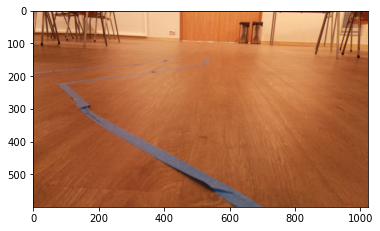

In [24]:
# import data
image_paths = []
commands = []
data_dir = 'sequences'
model_output_dir = 'model'

def mapAction(action: str)-> int:
    actionsMap = {
        'forward': 1,
        'backward': 2,
        'left': 3,
        'right': 4
    }
    return actionsMap[action]

for subdir, dirs, files in os.walk(data_dir):
    for sdir in dirs: 
        file = open(os.path.join(data_dir, sdir,'sequence.json'))
        sequence = json.load(file)
        for step in sequence['sequence']:
            image_paths.append(step['photo'])
            commands.append(mapAction(step['action']))

print(commands, image_paths)    


image_index = 17
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("command: %d" % commands[image_index] )
df = pd.DataFrame()
df['image_path'] = image_paths
df['command'] = commands

(array([40.0000, 0.0000, 16.0000, 15.0000]),
 array([1.0000, 1.7500, 2.5000, 3.2500, 4.0000]),
 <BarContainer object of 4 artists>)

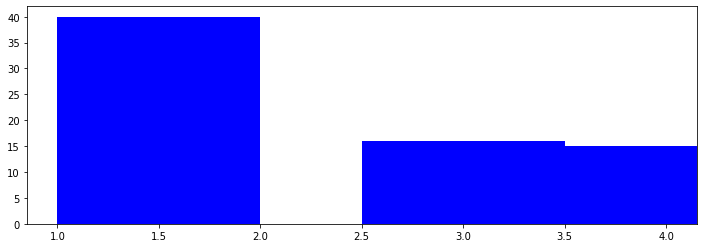

In [25]:
# Look at the distribution of commands
# distribution has to be balanced
num_of_bins = 4
samples_per_bin = 20
hist, bins = np.histogram(df['command'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['command'], bins=num_of_bins, width=1, color='blue')

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, commands, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))


Training data: 56
Validation data: 15


##Image Augumentation
Since we only have a few hundred images, to train a deep network, we need a lot more images.   Instead of running our car, let's try to augment our data. There are a couple of ways to do that.

1. Zoom: crop out a smaller image from the center
1. Pan: crop out a smaller image from left or right side
1. adjust brightness of the image
1. flip the image horizontally, i.e do a left to right flip, and change the steering angle coorespondingly
1. introduce an Gaussian blur

We can combine the above augmentation techniques to generate 100s times of the training images, with just a few hundred real images.



Text(0.5, 1.0, 'zoomed')

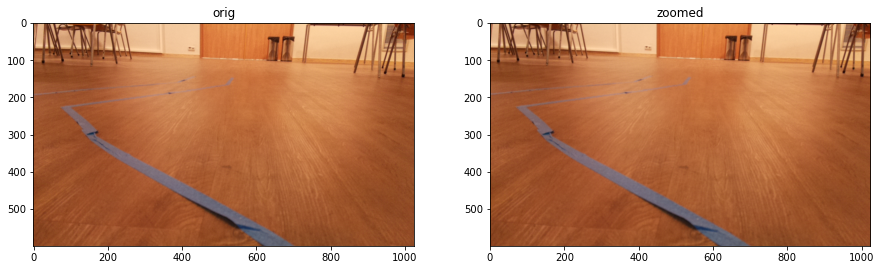

In [27]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_zoom = zoom(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_zoom)
axes[1].set_title("zoomed")


Text(0.5, 1.0, 'panned')

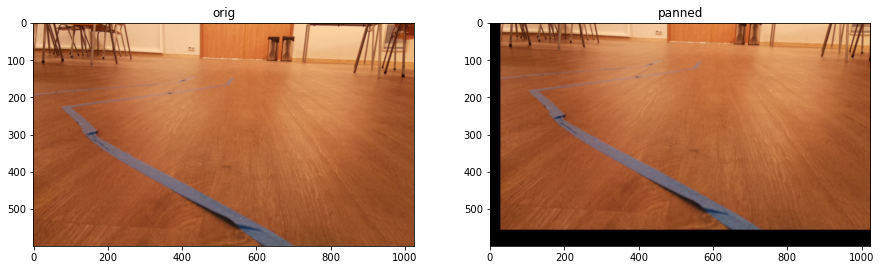

In [28]:
def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_pan = pan(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_pan)
axes[1].set_title("panned")


Text(0.5, 1.0, 'brightness adjusted')

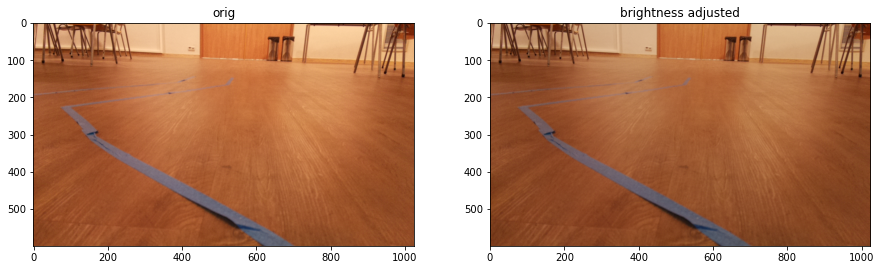

In [29]:
def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_brightness = adjust_brightness(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_brightness)
axes[1].set_title("brightness adjusted")

Text(0.5, 1.0, 'blurred')

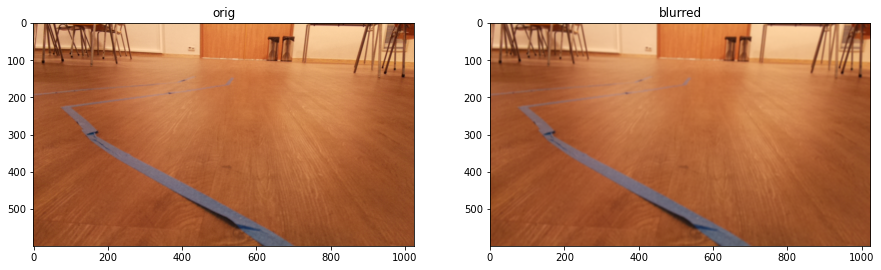

In [30]:
def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
   
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_blur = blur(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_blur)
axes[1].set_title("blurred")

Text(0.5, 1.0, 'flipped, command=1, original=1')

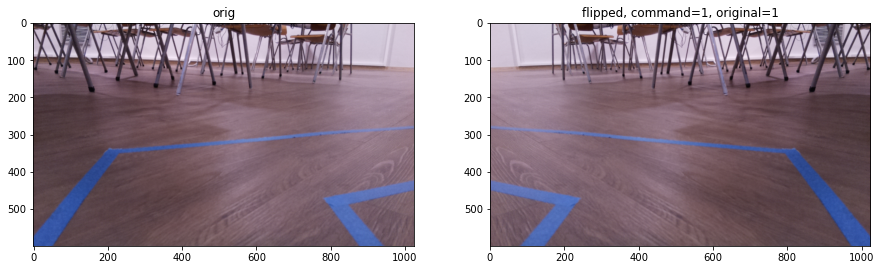

In [31]:
def random_flip(image, oldCommand):
    is_flip = random.randint(0, 1)
    command = oldCommand
    if is_flip == 1:
        # randomly flip horizon
        image = cv2.flip(image,1)
        if 3 == oldCommand:
            command = 4
        if 4 == oldCommand:
            command = 3
   
    return image, command

image_index = 20
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_flip, command = random_flip(image_orig, commands[image_index])
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_flip)
axes[1].set_title("flipped, command=%s, original=%s" % (command, commands[image_index]))

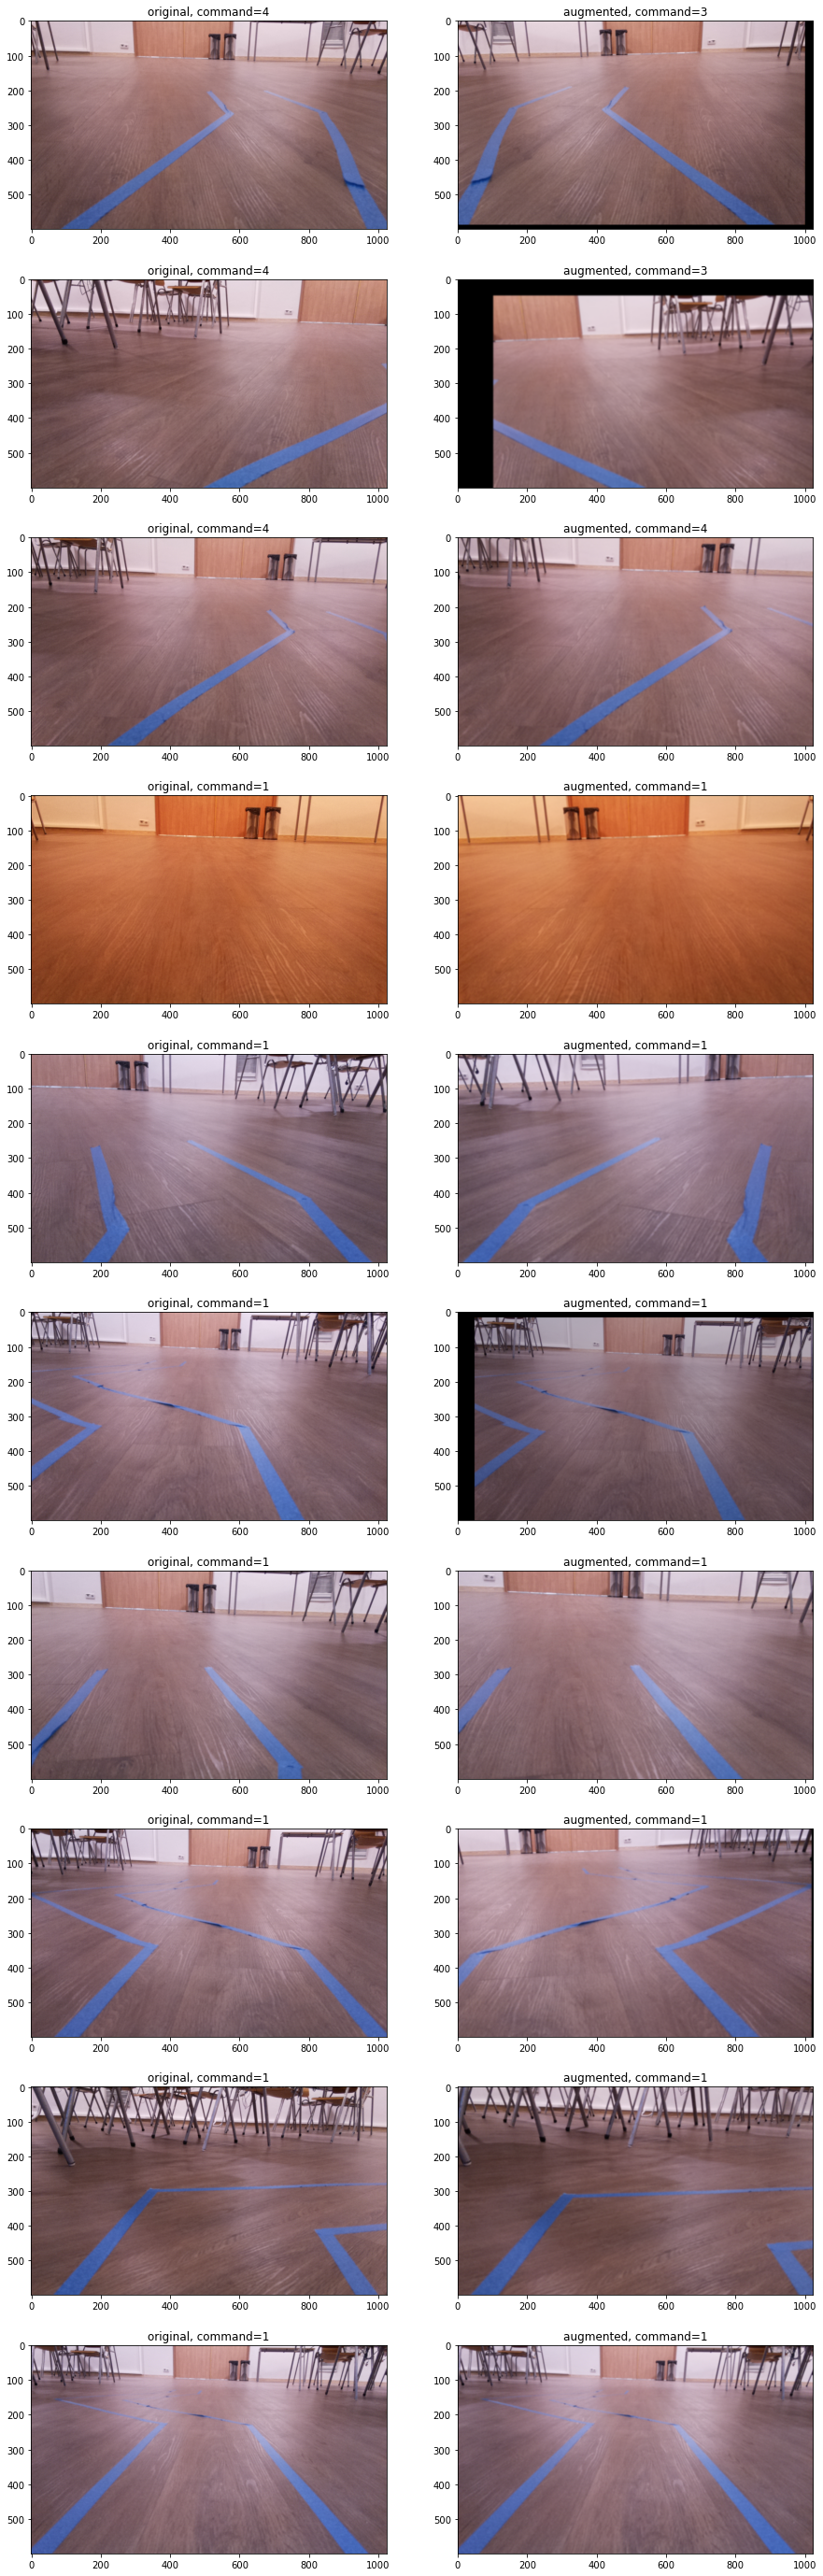

In [32]:
# put it together
def random_augment(image, command):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    image, command = random_flip(image, command)
    
    return image, command

# show a few randomly augmented images
ncol = 2
nrow = 10
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))

for i in range(nrow):
    rand_index = random.randint(0, len(image_paths) - 1)
    image_path = image_paths[rand_index]
    command_orig = commands[rand_index]
    
    image_orig = my_imread(image_path)
    image_aug, command_aug = random_augment(image_orig, command_orig)
    
    axes[i][0].imshow(image_orig)
    axes[i][0].set_title("original, command=%s" % command_orig)
    axes[i][1].imshow(image_aug)
    axes[i][1].set_title("augmented, command=%s" % command_aug)
    

## Preprocess Training Data for Nvidia Model

Text(0.5, 1.0, 'processed')

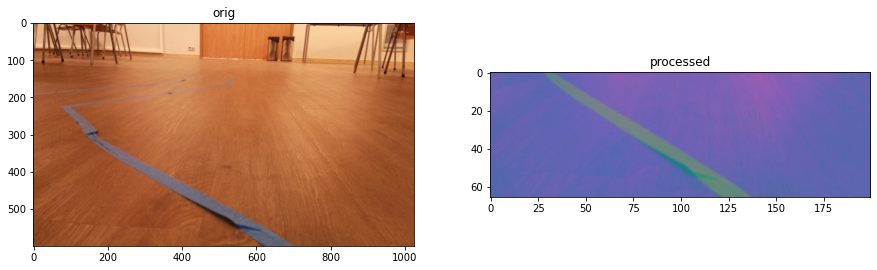

In [33]:
image_index = 17
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relavant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing, the processed image becomes black for some reason.  do we need this?
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")


## Create and Train Model

In [34]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1)) 
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Adam(lr=1e-3) # lr is learning rate
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [35]:
model = nvidia_model()
print(model.summary())
# check at we will have 252,219 trainable parameters

Model: "Nvidia_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 dropout_2 (Dropout)         (None, 3, 20, 64)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten_1 (Flatten)         (None, 1152)             

/home/michal/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [36]:
def image_data_generator(image_paths, commands, batch_size, is_training):
    while True:
        batch_images = []
        batch_commands = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            command = commands[random_index]
            if is_training:
                # training: augment image
                image, command = random_augment(image, command)
              
            image = img_preprocess(image)
            batch_images.append(image)
            batch_commands.append(command)
            
        yield( np.asarray(batch_images), np.asarray(batch_commands))
            
            

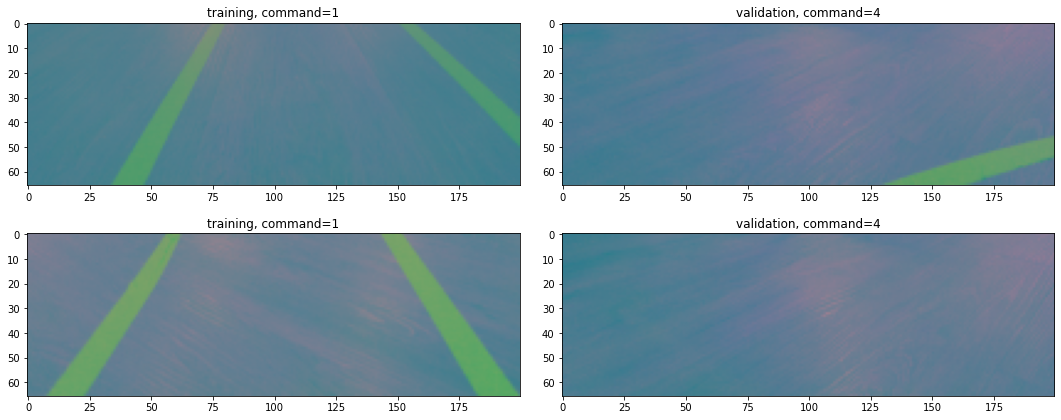

In [37]:
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow, True))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow, False))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, command=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, command=%s" % y_valid_batch[i])


In [38]:
# start Tensorboard before model fit, so we can see the epoch tick in Tensorboard
# Jupyter Notebook embedded Tensorboard is a new feature in TF 2.0!!  

# clean up log folder for tensorboard
log_dir_root = f'{model_output_dir}/logs/'
#!rm -rf $log_dir_root


In [39]:
# this block prevents the training from starting if we Run All
DO_NOT_RUN_ALL

NameError: name 'DO_NOT_RUN_ALL' is not defined

In [40]:
# saves the model weights after each epoch if the validation loss decreased
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'lane_navigation_check.h5'), verbose=1, save_best_only=True)

print("lane nav train started")
history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=100, is_training=True),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=100, is_training=False),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir,'lane_navigation_final.h5'))

date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
    
print("lane nav train finished. val_loss from %.1f to %.1f" % (history.history['val_loss'][0], history.history['val_loss'][-1]))


lane nav train started


/tmp/ipykernel_4603/3397368884.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=100, is_training=True),


Epoch 1/10
300/300 [==============================] - ETA: 0s - loss: 1.1795
Epoch 1: val_loss improved from inf to 2.06892, saving model to model/lane_navigation_check.h5
300/300 [==============================] - 590s 2s/step - loss: 1.1795 - val_loss: 2.0689
Epoch 2/10
300/300 [==============================] - ETA: 0s - loss: 0.3082
Epoch 2: val_loss improved from 2.06892 to 0.56147, saving model to model/lane_navigation_check.h5
300/300 [==============================] - 598s 2s/step - loss: 0.3082 - val_loss: 0.5615
Epoch 3/10
300/300 [==============================] - ETA: 0s - loss: 0.1446
Epoch 3: val_loss did not improve from 0.56147
300/300 [==============================] - 598s 2s/step - loss: 0.1446 - val_loss: 0.7111
Epoch 4/10
300/300 [==============================] - ETA: 0s - loss: 0.0838
Epoch 4: val_loss did not improve from 0.56147
300/300 [==============================] - 596s 2s/step - loss: 0.0838 - val_loss: 0.8118
Epoch 5/10
300/300 [========================

## Check Trained Model on Validation Data

In [41]:
history.history


{'loss': [1.179514765739441,
  0.308231920003891,
  0.14463405311107635,
  0.08381444215774536,
  0.059324223548173904,
  0.047127865254879,
  0.03944379463791847,
  0.030191684141755104,
  0.028281185775995255,
  0.02388143353164196],
 'val_loss': [2.0689189434051514,
  0.5614739060401917,
  0.7111062407493591,
  0.8118454813957214,
  0.6265060305595398,
  0.8070327639579773,
  0.6711899638175964,
  0.8155477643013,
  0.8338059782981873,
  0.811527669429779]}

In [42]:
# plot training and validation losses
# this should be the same as tensorboard
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

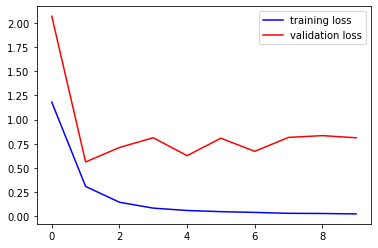

In [43]:
history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

In [83]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/lane_navigation_check.h5')
    Y_pred2 = []
    Y_pred = model.predict(X)
    for y in Y_pred:
        if (y < 3):
            Y_pred2.append(1)
        elif(y >= 3.2110):
            Y_pred2.append(4)
        else:
            Y_pred2.append(y)
    summarize_prediction(Y, Y_pred2)
    for y in zip(Y, Y_pred):
        print(y)
    return Y_pred

4/4 [==============================] - 0s 8ms/step
mse       = 0.23
r_squared = 88.11%

(4, array([4.0612], dtype=float32))
(4, array([3.6936], dtype=float32))
(3, array([3.2128], dtype=float32))
(4, array([3.2110], dtype=float32))
(1, array([2.3716], dtype=float32))
(4, array([3.7424], dtype=float32))
(1, array([1.6368], dtype=float32))
(1, array([2.3716], dtype=float32))
(3, array([3.0617], dtype=float32))
(1, array([0.7350], dtype=float32))
(1, array([1.2150], dtype=float32))
(4, array([3.6936], dtype=float32))
(4, array([3.7424], dtype=float32))
(1, array([2.3716], dtype=float32))
(4, array([4.0612], dtype=float32))
(1, array([0.4959], dtype=float32))
(1, array([2.3716], dtype=float32))
(1, array([3.1983], dtype=float32))
(4, array([3.2110], dtype=float32))
(4, array([3.2110], dtype=float32))
(1, array([1.6368], dtype=float32))
(1, array([0.9251], dtype=float32))
(1, array([1.6368], dtype=float32))
(4, array([3.7424], dtype=float32))
(1, array([0.7350], dtype=float32))
(1, array([3

/home/michal/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/home/michal/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
/home/michal/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:746: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-o

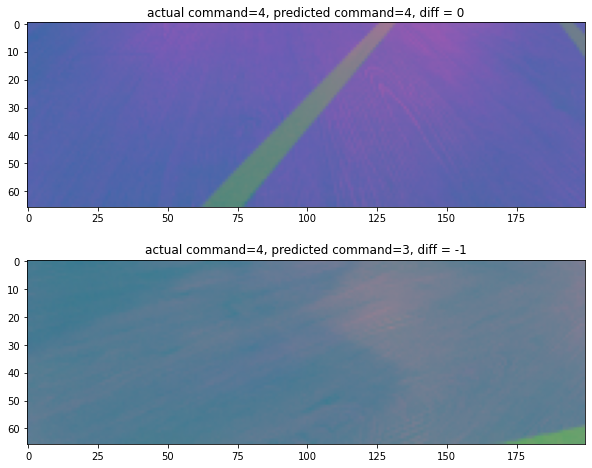

In [84]:
n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100, False))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 2
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual command={y_test[i]}, predicted command={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")
    

As we can see the $R^2$ of the predicted was around 95% and Mean Squared Errors (MSE) are low, indicating the model is predicting a steering angle every simliar to our hand coded land follower, which was used as the model input. 